In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
from fastai import *
from fastai.vision import *
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/')

['val', 'train', '.DS_Store', 'test']

In [4]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
# create a data bunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train='train',valid='test',test='val',
                                  ds_tfms=get_transforms(do_flip=False),
                                  size=224,bs=64,
                                  num_workers=1).normalize(imagenet_stats)

In [5]:
data

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray;

Valid: LabelList (624 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray;

Test: LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray

In [6]:
data.classes

['NORMAL', 'PNEUMONIA']

In [7]:
data.c

2

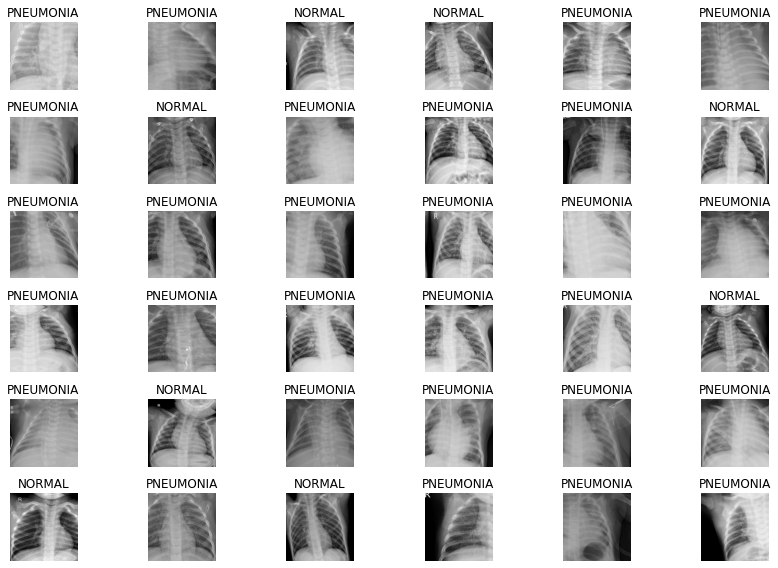

In [8]:
data.show_batch(rows=6,figsize=(12,8))

In [9]:
learn = create_cnn(data,models.resnet34,metrics=error_rate,model_dir="/tmp/model/")
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


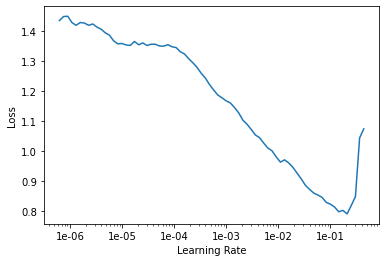

In [10]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,time
0,0.568936,0.236334,0.062500,04:18
1,0.291176,0.512687,0.250000,04:17
2,0.199623,0.164983,0.062500,04:14
3,0.148774,0.109035,0.062500,04:18
4,0.128583,0.101202,0.062500,04:10


In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.431445,0.552668,0.160256,04:40
1,0.258748,0.356767,0.120192,04:44
2,0.191895,0.361863,0.134615,04:44
3,0.152553,0.324801,0.108974,04:46


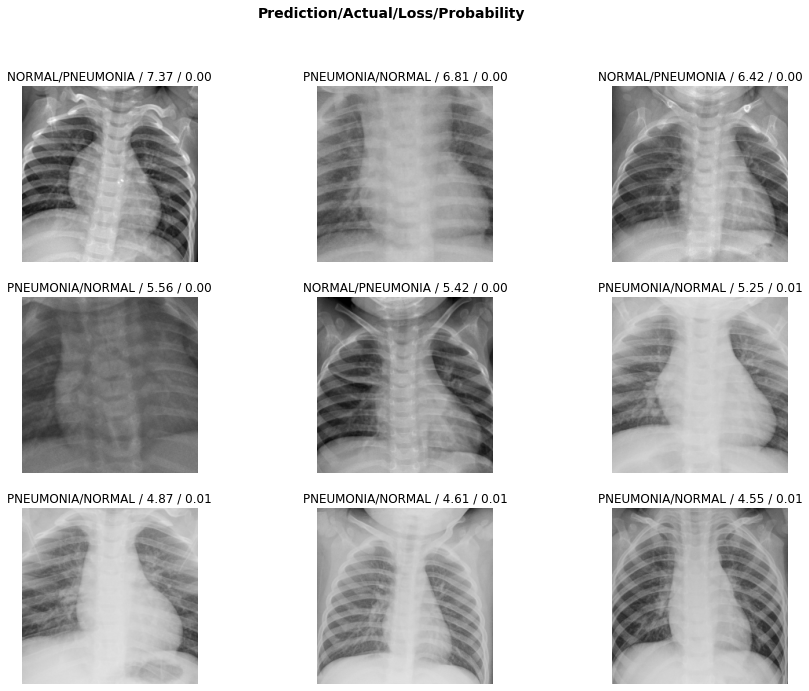

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
# plot the top losses
interp.plot_top_losses(9, figsize=(15,11))

Confusion Matrix

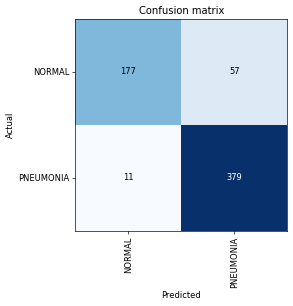

In [13]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.153332,0.266672,0.081731,04:46
1,0.094233,0.369566,0.118590,04:47


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


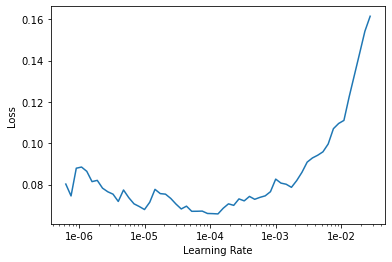

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
# we select the slice with the steepest slope
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.053158,0.285564,0.097756,04:41


# interpret the results

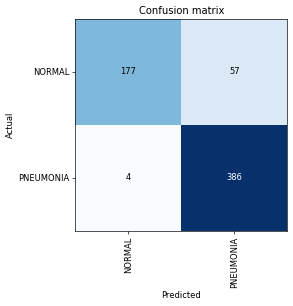

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

# Predictions for test Images

In [20]:
preds,y =learn.get_preds(DatasetType.Test)

In [21]:
labels = preds.numpy()

In [22]:
labels.shape

(16, 2)

In [23]:
data.test_ds

LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray

In [27]:
predictions = [i.argmax().item() for i in labels]

In [28]:
predictions

[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [44]:
os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/')

['NORMAL2-IM-1431-0001.jpeg',
 'NORMAL2-IM-1427-0001.jpeg',
 'NORMAL2-IM-1430-0001.jpeg',
 '.DS_Store',
 'NORMAL2-IM-1437-0001.jpeg',
 'NORMAL2-IM-1442-0001.jpeg',
 'NORMAL2-IM-1438-0001.jpeg',
 'NORMAL2-IM-1440-0001.jpeg',
 'NORMAL2-IM-1436-0001.jpeg']

In [45]:
images = []
labels = []
for image in os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/'):
    if image != '.DS_Store':
        images.append(image)
        labels.append(0)

In [46]:
for image in os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/'):
     if image != '.DS_Store':
        images.append(image)
        labels.append(1)

In [47]:
import pandas as pd
results = pd.DataFrame({'Image_Name':images,'Actual_Label':labels})

In [48]:
results.shape

(16, 2)

In [49]:
results['Predicted_Label'] = predictions

In [50]:
results

,Image_Name,Actual_Label,Predicted_Label
0,NORMAL2-IM-1431-0001.jpeg,0,0
1,NORMAL2-IM-1427-0001.jpeg,0,1
2,NORMAL2-IM-1430-0001.jpeg,0,0
3,NORMAL2-IM-1437-0001.jpeg,0,1
4,NORMAL2-IM-1442-0001.jpeg,0,0
5,NORMAL2-IM-1438-0001.jpeg,0,0
6,NORMAL2-IM-1440-0001.jpeg,0,0
7,NORMAL2-IM-1436-0001.jpeg,0,0
8,person1946_bacteria_4875.jpeg,1,1
9,person1952_bacteria_4883.jpeg,1,1


In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(results['Predicted_Label'].values,results['Actual_Label'].values)

0.875

# Infected Image

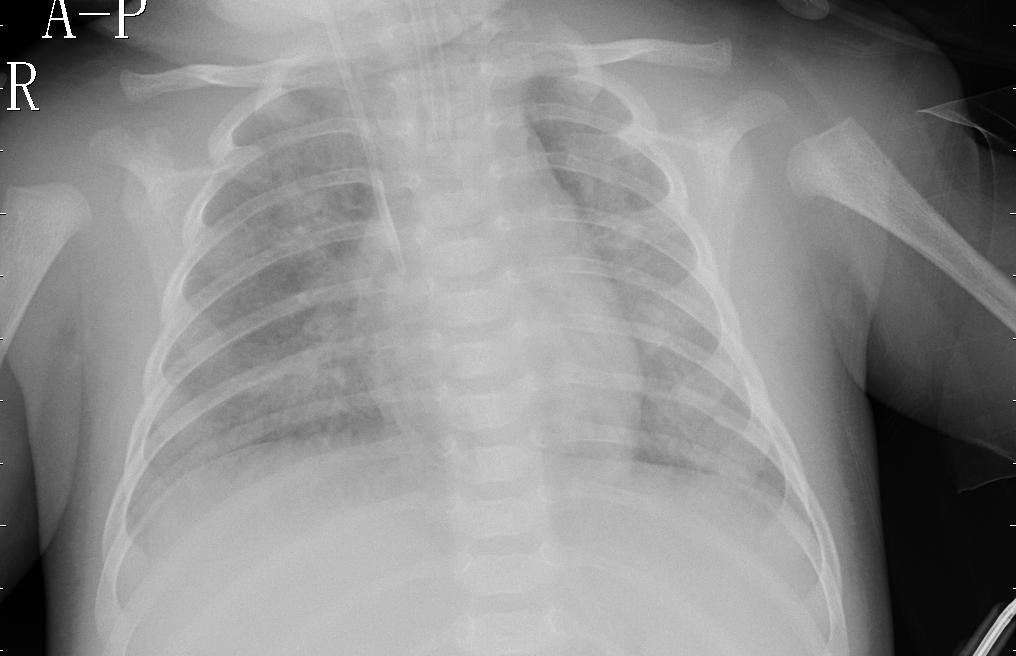

In [2]:
import PIL
PIL.Image.open('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg')